In [22]:
%pip install -r ../requirements.txt
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



[notice] A new release of pip available: 22.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
# Import necessary libraries
import sys
import os
import shutil
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(os.path.join(os.pardir, 'src')))

# Import project-specific internal modules
from preprocessor import DataPreprocessor
from plots import PlotGenerator
from src import config
from config import RUN_CONFIGURATION, EMOTION_STATES, NLP_CONFIG, SENTIMENT_MODEL_EXPORT_PATH_RAW, \
    SENTIMENT_MODEL_EXPORT_PATH_OPTIMIZED, EMOTION_VARIATIONS_PATH, NEGATION_PATTERNS_PATH, \
    HYPERPARAMETERS, RANDOM_STATE, PREDICTION_MODEL_EXPORT_PATH, TOPIC_MODEL_EXPORT_PATH, \
    is_step_enabled
from src.sentiment_analysis import SentimentAnalysisModel
from src.emotion_postprocessor import EmotionPostProcessor
from src.clinical_notes_prediction import ClinicalNotesNoShowPredictor
from clinical_topic_model import ClinicalTopicModel
from src import config
from src.plots import PlotGenerator

# Create an instance of the preprocessing and plotting classes
preprocessor = DataPreprocessor(config)
plotter = PlotGenerator(style='whitegrid', palette='viridis', figsize=(10, 6))

sns.set(style='whitegrid')
warnings.filterwarnings("ignore")

In [24]:
if is_step_enabled('dataload'):
    df = preprocessor.load_data(config.DATASET_PATH)
    display("shape:", df.shape)
    display("columns:", df.columns)
    display(df.head())
    display(df.describe())

'shape:'

(110527, 17)

'columns:'

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'PatientNotes', 'PatientSentiment', 'NoShowReason'],
      dtype='object')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,PatientNotes,PatientSentiment,NoShowReason
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,This patient has a longstanding history of ele...,Patient is generally positive and engaged in c...,"Satisfaction with previous care, including suc..."
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,No chronic conditions or significant health co...,Patient is generally positive and engaged in c...,"Encouragement from family members, especially ..."
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No,No chronic conditions or significant health co...,Patient feels hopeful and confident about mana...,"A recent health scare, such as a hospitalizati..."
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,Child accompanied by parent/guardian. Reviewed...,Patient feels hopeful and confident about mana...,The patient is focused on improving overall qu...
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No,Patient with hypertension is tracking salt int...,Patient feels hopeful and confident about mana...,"Encouragement from family members, especially ..."


,PatientId,AppointmentID,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


# Pre Processing

In [25]:
if is_step_enabled('data_preprocess'):
    df = preprocessor.preprocess_data(df)
    display("shape:", df.shape)
    display("columns:", df.columns)
    display(df.head())
    display(df.describe())

[preprocessing] Starting preprocessing...
Initial shape of the dataset: (110527, 17)
Initial columns in the dataset: Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'PatientNotes', 'PatientSentiment', 'NoShowReason'],
      dtype='object')
Dropping unnecessary columns...
Remaining columns: Index(['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood',
       'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handcap',
       'SMS_received', 'No-show', 'PatientNotes', 'PatientSentiment',
       'NoShowReason'],
      dtype='object')
Converting date columns to datetime...
Handling missing values...
Adding emotional state columns...
Handling missing values...
Adding emotional state columns...
Emotional state columns added: ['anxiety', 'stress', 'confusion', 'hopeful', 'fear']
Final shape of the datas

'shape:'

(110527, 21)

'columns:'

Index(['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood',
       'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handcap',
       'SMS_received', 'No-show', 'PatientNotes', 'PatientSentiment',
       'NoShowReason', 'WaitDays', 'anxiety', 'stress', 'confusion', 'hopeful',
       'fear'],
      dtype='object')

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,...,No-show,PatientNotes,PatientSentiment,NoShowReason,WaitDays,anxiety,stress,confusion,hopeful,fear
0,0,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62.0,JARDIM DA PENHA,0,1,0,0,0,...,0,This patient has a longstanding history of ele...,Patient is generally positive and engaged in c...,"Satisfaction with previous care, including suc...",-1,0,1,0,1,0
1,1,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56.0,JARDIM DA PENHA,0,0,0,0,0,...,0,No chronic conditions or significant health co...,Patient is generally positive and engaged in c...,"Encouragement from family members, especially ...",-1,1,1,0,0,1
2,0,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62.0,MATA DA PRAIA,0,0,0,0,0,...,0,No chronic conditions or significant health co...,Patient feels hopeful and confident about mana...,"A recent health scare, such as a hospitalizati...",-1,1,1,0,1,1
3,0,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8.0,PONTAL DE CAMBURI,0,0,0,0,0,...,0,Child accompanied by parent/guardian. Reviewed...,Patient feels hopeful and confident about mana...,The patient is focused on improving overall qu...,-1,1,1,0,1,1
4,0,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56.0,JARDIM DA PENHA,0,1,1,0,0,...,0,Patient with hypertension is tracking salt int...,Patient feels hopeful and confident about mana...,"Encouragement from family members, especially ...",-1,0,1,0,1,0


,Gender,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitDays,anxiety,stress,confusion,hopeful,fear
count,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.0,110527.0,110527.000000,110527.000000
mean,0.350023,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,0.201933,9.183702,0.667158,1.0,0.0,0.665810,0.667158
std,0.476979,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,0.401444,15.254996,0.471233,0.0,0.0,0.471709,0.471233
min,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.000000,0.000000,1.0,0.0,0.000000,0.000000
25%,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,1.0,0.0,0.000000,0.000000
50%,0.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.0,0.0,1.000000,1.000000
75%,1.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,14.000000,1.000000,1.0,0.0,1.000000,1.000000
max,1.000000,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,178.000000,1.000000,1.0,0.0,1.000000,1.000000


In [26]:
# Topic Modeling for Diabetes, Hypertension, Alcoholism using ClinicalTopicModel class and project architecture
if is_step_enabled('nlp_topic_modeling'):
    model = ClinicalTopicModel(config)
    conditions = ['diabetes', 'hypertension', 'alcohol']
    perplexities = []
    silhouette_scores = []
    all_topics = []

    for cond in conditions:
        df_cond = model.preprocess_notes(df, cond)
        if df_cond.empty:
            print(f"Skipping {cond}: No clinical concepts found after MedSpaCy extraction.")
            perplexities.append(None)
            silhouette_scores.append(None)
            all_topics.append([])
            continue
        model.train(df_cond['PatientNotes_clean'])
        perplexity, sil_score = model.evaluate(df_cond['PatientNotes_clean'])
        print(f"\n--- {cond.title()} ---")
        print(f"Model Perplexity: {perplexity:.2f}")
        if sil_score is not None:
            print(f"Silhouette Score: {sil_score:.2f}")
        topics = model.get_topics(n_top_words=10)
        for idx, topic_words in enumerate(topics):
            print(f"Topic {idx+1}: {' '.join(topic_words)}")
        perplexities.append(perplexity)
        silhouette_scores.append(sil_score if sil_score is not None else 0)
        all_topics.append(topics)

Fitting 2 folds for each of 5 candidates, totalling 10 fits

--- Diabetes ---
Model Perplexity: 8.93
Silhouette Score: 0.29
Topic 1: hba1c type_2_diabetes diabetes insulin diabetic_retinopathy metformin diabetic hypoglycemia alcoholism alcohol_use_disorder
Topic 2: hypertension diabetes elevated_blood_pressure hba1c blood_pressure fasting_glucose amlodipine metformin type_2_diabetes insulin

--- Diabetes ---
Model Perplexity: 8.93
Silhouette Score: 0.29
Topic 1: hba1c type_2_diabetes diabetes insulin diabetic_retinopathy metformin diabetic hypoglycemia alcoholism alcohol_use_disorder
Topic 2: hypertension diabetes elevated_blood_pressure hba1c blood_pressure fasting_glucose amlodipine metformin type_2_diabetes insulin
Fitting 2 folds for each of 5 candidates, totalling 10 fits
Fitting 2 folds for each of 5 candidates, totalling 10 fits

--- Hypertension ---
Model Perplexity: 10.28
Silhouette Score: 0.24
Topic 1: diabetes hba1c elevated_blood_pressure fasting_glucose diabetic ast alt am

Visualizing clinical entities for a note 1:


Visualizing clinical entities for a note 2:


Visualizing clinical entities for a note 3:


Visualizing clinical entities for a note 4:


Visualizing clinical entities for a note 5:


Visualizing clinical entities for a note 6:


Visualizing clinical entities for a note 7:


Visualizing clinical entities for a note 8:


Visualizing clinical entities for a note 9:


Visualizing clinical entities for a note 10:


Visualizing clinical entities for a note:


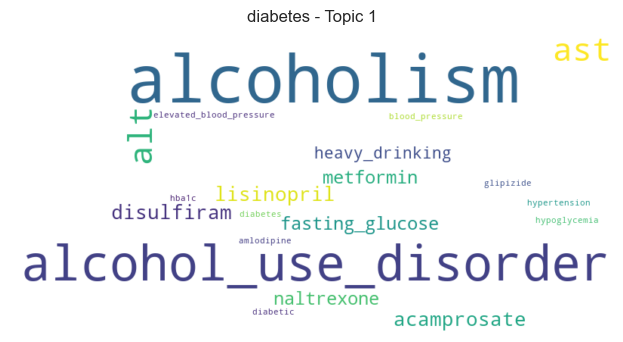

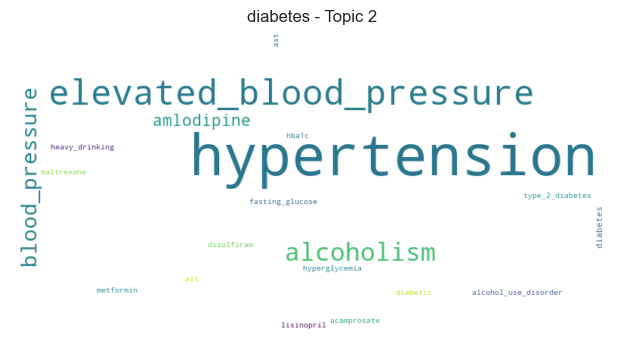

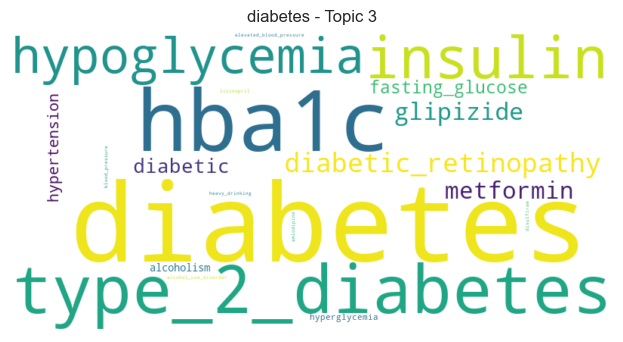

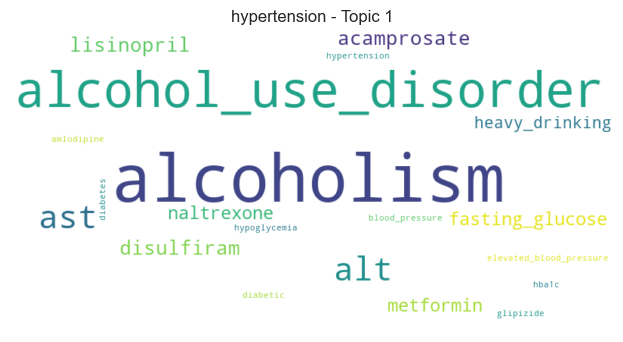

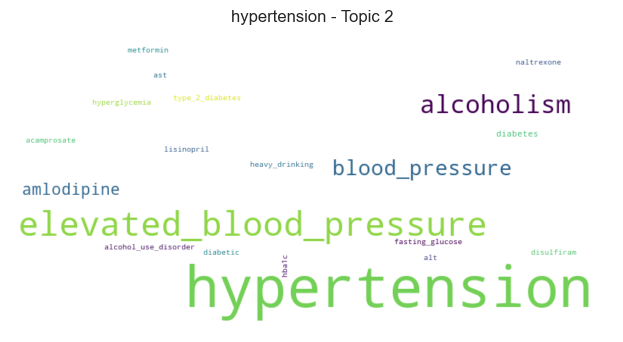

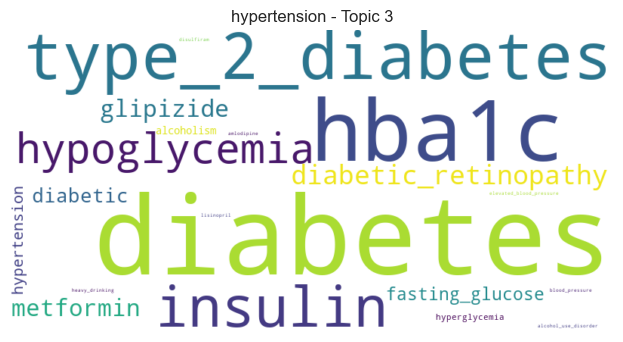

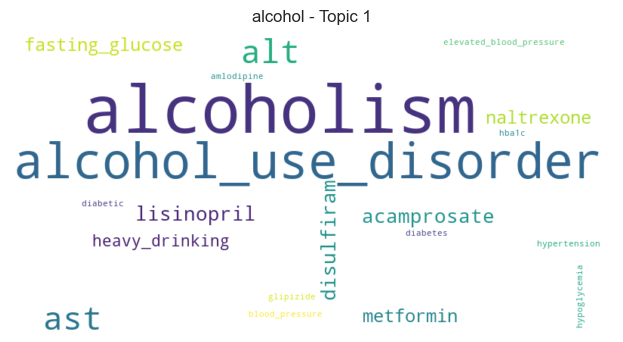

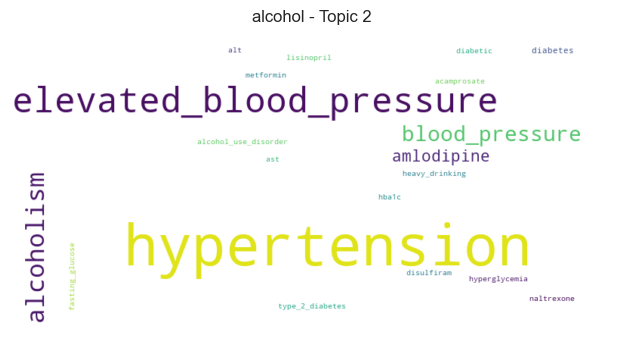

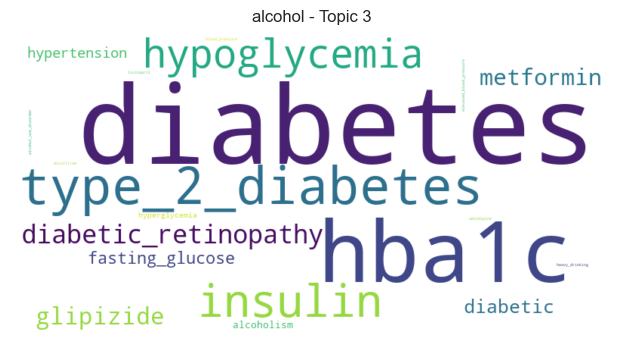

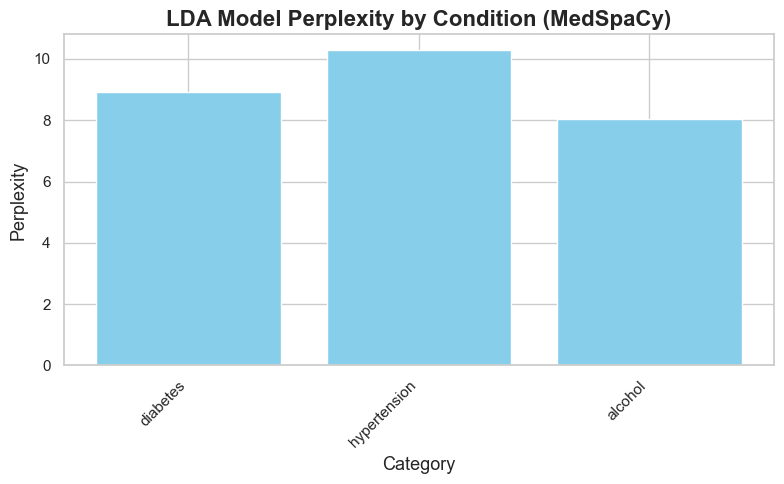

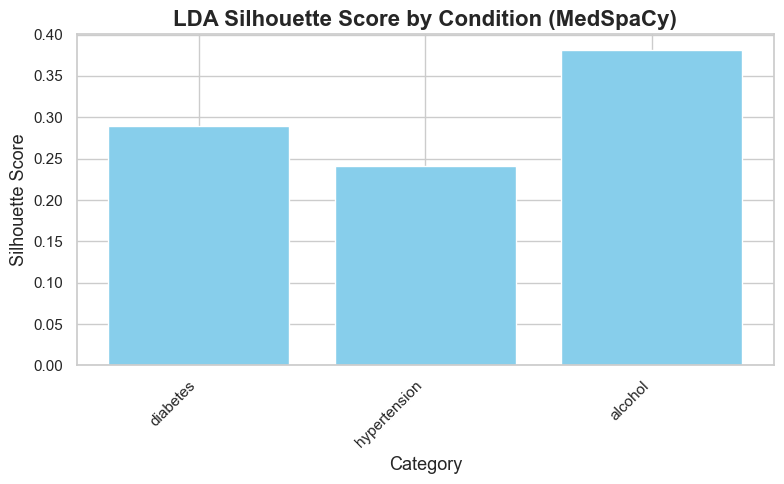

In [27]:
if is_step_enabled('nlp_topic_modeling'):

    # Visualize clinical entities for a note after topic modeling
    if not df_cond.empty:
        # Visualize clinical entities for 10 notes after topic modeling
        for i in range(min(10, len(df_cond))):
            sample_note = df_cond['PatientNotes'].iloc[i]
            print(f'Visualizing clinical entities for a note {i+1}:')
            model.plot_medspacy_ents(sample_note)
        print('Visualizing clinical entities for a note:')
        model.plot_medspacy_ents(sample_note)
    else:
        print('No notes available for visualization.')

    # Plot word clouds for each condition after the loop
    for cond in conditions:
        plotter.plot_wordclouds(model.model, model.vectorizer, cond)

    # Plot Perplexity and Silhouette Score using plotter
    plotter.plot_bar(conditions, perplexities, title='LDA Model Perplexity by Condition (MedSpaCy)', ylabel='Perplexity')
    plotter.plot_bar(conditions, silhouette_scores, title='LDA Silhouette Score by Condition (MedSpaCy)', ylabel='Silhouette Score')

In [28]:
if is_step_enabled('nlp_topic_modeling'):
    # Export the trained topic model and vectorizer
    model.export(TOPIC_MODEL_EXPORT_PATH)
    print(f"Model and vectorizer exported to: {TOPIC_MODEL_EXPORT_PATH}_lda_model.joblib and {TOPIC_MODEL_EXPORT_PATH}_vectorizer.joblib")

Model and vectorizer exported to: d:\Personal\AI-Admissions\Semester 3\AAI-510 - Machine learning Fundamentals and Applications\Final Team Project\aai510_3proj\models\nlp\topic_model_lda_model.joblib and d:\Personal\AI-Admissions\Semester 3\AAI-510 - Machine learning Fundamentals and Applications\Final Team Project\aai510_3proj\models\nlp\topic_model_vectorizer.joblib
